# DENOISING DIFFUSION IMPLICIT MODELS (DDIM)
Prepared by Rodulfo Dela Paz Alfafara II 

For this task, we will be implementing a (DDIM) Denoising Diffusion Implicit Model using PyTorch on the CIFAR 10 dataset. The implementation here will closely follow the principles discussed in the DENOISING DIFFUSION IMPLICIT MODELS paper by Song et al of Stanford University. We will be using CIFAR10 dataset as inputs which is a very popular dataset with 60,000 32x32 colour images distributed evenly across 10 classes. 

In [1]:
#imported necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
import math
from einops import parse_shape, rearrange
from dataclasses import dataclass
import time
from argparse import ArgumentParser
import logging
from einops import rearrange
from matplotlib import pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split
import zipfile
import pickle
from torch import nn
from PIL import Image
import io
from scipy.linalg import sqrtm
import matplotlib.image as mpimg
import torch.nn.functional as F
import torchvision.transforms as transforms

# DDIM Implementation

## UNet Architecture Setup

For our DDIM Implementation, we will be leveraging on the UNet Architecture as it is widely being used in the real world. U-Net is a convolutional neural network (CNN) architecture originally designed for biomedical image segmentation, first introduced by Ronneberger et al in the paper U-Net: Convolutional Networks for Biomedical Image Segmentation. It follows a U-shape, hence the name, which consists of an encoder phase that handles downsampling followed by a decoder phase that handles upsampling.Encoder aims to reduce the spatial dimensions of the input image while increasing the number of feature channels, enabling the model to extract features. Contrary to the encoder, the decoder aims to increase the spatial dimensions of the feature maps while decreasing the number of feature channels, allowing the model to generate segmentation masks with the same spatial resolution as the input image. Skip connections are established between the encoder and decoder so that fine-grained details lost during downsampling can be recovered.

U-Net is formed by a series of ResNet blocks arranged into a set of downsamples followed by an opposing set of upsamples. From the paper Denoising Diffusion Probabilistic Models, researchers Ho et al proposed two modifications to the UNet Architecture. First proposal made was to add self-attention layers to allow feature-sharing globally instead of the traditional implementation of solely leveraging on local convolutions. Secondly, they proposed to use sinusoidal embeddings for embedding t or the temporal dimension, which is subsequently passed through a feed-forward network that modifies the biases of activations in each ResNet block, after passing through each batch normalization layers. Then,in terms of the design of the ResNet blocks to be used in this architecture, we will closely follow the principles discussed from the paper Deep Residual Learning for Image Recognition by He et al as proposed by Tony Duan. We will adopt the method done by the researchers from the paper when they worked on the Cifar 10 dataset. In their research, they used a pair of 3x3 convolutional layers followed by a residual connection. Then, after each convolutional operation, ReLU activation function is applied, where outputs are added to the tensor. The residual connection bypasses the convolutional layers and directly feeds the original input tensor to the output, employing residual learning through shortcut connections.

In [2]:
#defined a function that ensures that the input tensor has at least the desired number of dimensions 
#If the input tensor already has more dimensions than or equal to the target dimensions, the function returns the input tensor 
#without any changes. If the input tensor has fewer dimensions than the target, it adds dimensions to the tensor until it 
#reaches the desired number of dimensions.
def unsqueeze_to(tensor, target_ndim):#takes a tensor and the desired number of dimensions for the tensor as arguments
    assert tensor.ndim <= target_ndim #raises an assertion error, if the input tensor already has more dimensions than the target
    while tensor.ndim < target_ndim:#loop continues until the number of dimensions of the tensor is equal to the target number of dimensions
        tensor = tensor.unsqueeze(-1)#adds a new dimension at the end of the tensor until the loop is being continued
    return tensor

#defined a function that modifies the input tensor to have the same number of dimensions as the target_tensor
#basically this behaves similar to the function above except that its target is a tensor instead of dimensions
def unsqueeze_as(tensor, target_tensor):
    assert tensor.ndim <= target_tensor.ndim
    while tensor.ndim < target_tensor.ndim:
        tensor = tensor.unsqueeze(-1)
    return tensor

#defined a class that incorporates positional information into the input embeddings, allowing the model to understand the 
#sequential order of the input data.
class PositionalEmbedding(nn.Module):
    def __init__(self, dim, max_length=10000):#initializes the embedding
        super().__init__()#calls nn.Module
        self.register_buffer("embedding", self.make_embedding(dim, max_length))#creates the positional embedding using the make_embedding method and registers it as a buffer in the module
        #This allows the embedding to be moved along with the model's parameters
        
    def forward(self, x):#defined the forward pass function of this class which takes an input tensor x, that represents the positions
        # Parameters
        #   x: (bsz,) discrete
        return self.embedding[x]#returns the embeddings corresponding to the positions

    @staticmethod
    def make_embedding(dim, max_length=10000):#creates the positional embeddings
        embedding = torch.zeros(max_length, dim)#initializes an empty tensor embedding based on the input dimension and length
        position = torch.arange(0, max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(max_length / 2 / math.pi) / dim))
        #generates positional embeddings using sine and cosine functions
        embedding[:, 0::2] = torch.sin(position * div_term)
        embedding[:, 1::2] = torch.cos(position * div_term)
        return embedding

#defined a class that implements a basic building block for a convolutional neural network (CNN)
#This follows the design proposed by He et al from the paper Deep Residual Learning for Image Recognition as described above
class BasicBlock(nn.Module):
    # initializes the layers of the basic block
    def __init__(self, in_c, out_c, time_c): #takes number of input, output and time channels as arguments
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)#First convolutional layer with a 3x3 kernel
        self.bn1 = nn.BatchNorm2d(out_c)#Batch normalization layer after the first convolution
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)#Second convolutional layer with a 3x3 kernel
        self.bn2 = nn.BatchNorm2d(out_c)#Batch normalization layer after the second convolution
        self.mlp_time = nn.Sequential(#applied MLP (Multi-Layer Perceptron) to the time dimension
            nn.Linear(time_c, time_c),#consists of two linear layers with ReLU activation in between
            nn.ReLU(),
            nn.Linear(time_c, out_c),
        )#this block transforms the time information to have the same dimensionality as out_c
        #applies Short-cut connection to match the dimensions of the input and output if they differ.
        if in_c == out_c:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Sequential(#applies convolutional layer followed by batch normalization
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_c)
            )

    #defined the forward pass function of this BasicBlock            
    def forward(self, x, t):
        out = self.conv1(x)#applies the first convolutional layer
        out = self.bn1(out)#applies the Batch normalization layer after the first convolution
        out = F.relu(out + unsqueeze_as(self.mlp_time(t), x))#Adds the result of the first convolution and the result of the MLP applied to the time information (t)
        out = self.conv2(out)#applies the second convolutional layer
        out = self.bn2(out)#applies the Batch normalization layer after the second convolution
        out = F.relu(out + self.shortcut(x))#Adds the result of the second convolution and the result of the short-cut connection
        return out #Returns the final output.

#defined a class that implements the multi-head self-attention mechanism for 2D inputs
class SelfAttention2d(nn.Module):

    def __init__(self, dim, num_heads=8, dropout_prob=0.1):#initializes the self-attention class, where dimension, number of heads and probability dropout are taken as arguments
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        #Below are convolutional layers used to project the input features into query, key, and value spaces, respectively
        self.q_conv = nn.Conv2d(dim, dim, 1, bias=True)
        self.k_conv = nn.Conv2d(dim, dim, 1, bias=True)
        self.v_conv = nn.Conv2d(dim, dim, 1, bias=True)
        #Below is a convolutional layer that projects the concatenated outputs of the attention heads back to the original dimension
        self.o_conv = nn.Conv2d(dim, dim, 1, bias=True)
        self.dropout = nn.Dropout(dropout_prob)#applied Dropout layer to aid with overfitting
        
    #defined the forward pass of the SelfAttention2d class    
    def forward(self, x):
        #Below input tensor x is passed through the query, key, and value convolutional layers to obtain q,k, & v tensors, respectively
        q = self.q_conv(x)
        k = self.k_conv(x)
        v = self.v_conv(x)
        #Below reshapes the tensors to split the channels into multiple heads
        q = rearrange(q, "b (g c) h w -> (b g) c (h w)", g=self.num_heads)
        k = rearrange(k, "b (g c) h w -> (b g) c (h w)", g=self.num_heads)
        v = rearrange(v, "b (g c) h w -> (b g) c (h w)", g=self.num_heads)
        #Below, attention scores are computed using the scaled dot-product attention formula
        a = torch.einsum("b c s, b c t -> b s t", q, k) / self.dim ** 0.5
        a = self.dropout(torch.softmax(a, dim=-1))#computation is followed by the application of softmax along the last dimension
        #Below, the weighted sum of the values (v) based on attention scores (a) is computed using einsum (Einstein summation)
        o = torch.einsum("b s t, b c t -> b c s", a, v)#This gives the output tensor of the attention mechanism
        o = rearrange(o, "(b g) c (h w) -> b (g c) h w", g=self.num_heads, w=x.shape[-1])#the output tensor is rearranged back to the original shape
        return x + self.o_conv(o)#returns the result of adding the rearranged tensor to the result of the projection

#defined U-Net class that consists of an encoder (downsampling path) followed by a decoder (upsampling path), with skip connections between corresponding encoder and decoder layers
#This U-Net implementation is based on Phil Wang's UNet implementation, added with basic blocks and self-attention blocks within the encoder and decoder blocks. 
class UNet(nn.Module):
    def __init__(self, in_dim, embed_dim, dim_scales):#initializes U-Net, taking number of input channels, embedding & dim_scales as arguments
        super().__init__()#dim_scales is a tuple specifying the scaling factors for the dimensions of the encoder and decoder blocks

        self.init_embed = nn.Conv2d(in_dim, embed_dim, 1)#Convolutional layer that helps embed the input features into the specified embedding dimension
        self.time_embed = PositionalEmbedding(embed_dim)#Positional embedding layer, which provides temporal information to the model

        self.down_blocks = nn.ModuleList()#list of downsample blocks in the encoder
        self.up_blocks = nn.ModuleList()#list of upsample blocks in the decoder

        #Below is a tuple containing the dimensions of all the layers in the U-Net architecture
        #This includes the embedding dimension and scaled dimensions for the encoder and decoder blocks.
        #For example, if in_dim=1, embed_dim=32, dim_scales=(1, 2, 4, 8); then all_dims becomes >>(32, 32, 64, 128, 256)
        all_dims = (embed_dim, *[embed_dim * s for s in dim_scales])
        
        for idx, (in_c, out_c) in enumerate(zip(#iterates over the pairs of consecutive dimensions in all_dims, (encoder blocks)
            all_dims[:-1],
            all_dims[1:],
        )):
            is_last = idx == len(all_dims) - 2
            self.down_blocks.extend(nn.ModuleList([#represents the downsampling path of the U-Net
                BasicBlock(in_c, in_c, embed_dim),# For each pair of dimensions, two BasicBlock instances are added to the down_blocks
                BasicBlock(in_c, in_c, embed_dim),
                nn.Conv2d(in_c, out_c, 3, 2, 1) if not is_last else nn.Conv2d(in_c, out_c, 1),#nn.Conv2d layer is added with a stride of 2 to downsample the feature maps further,except for the last block where a convolution with a kernel size of 1 is used to maintain the spatial dimensions 
            ]))#In here, the spatial resolution of the feature maps is reduced while increasing the number of channels

        for idx, (in_c, out_c, skip_c) in enumerate(zip(#iterates over the pairs of consecutive dimensions in reverse order of all_dims,(decoder blocks)
            all_dims[::-1][:-1],
            all_dims[::-1][1:],
            all_dims[:-1][::-1],
        )):
            is_last = idx == len(all_dims) - 2
            self.up_blocks.extend(nn.ModuleList([#represents the upsampling path of the U-Net
                BasicBlock(in_c + skip_c, in_c, embed_dim),#similarly, two BasicBlock instances are added to the up_blocks
                BasicBlock(in_c + skip_c, in_c, embed_dim),
                nn.ConvTranspose2d(in_c, out_c, 2, 2) if not is_last else nn.Conv2d(in_c, out_c, 1),#a similar nn.ConvTranspose2d layer is added
            ]))

        self.mid_blocks = nn.ModuleList([
            BasicBlock(all_dims[-1], all_dims[-1], embed_dim),#BasicBlock for feature extraction
            SelfAttention2d(all_dims[-1]),#SelfAttention2d block
            BasicBlock(all_dims[-1], all_dims[-1], embed_dim),#BasicBlock for additional feature processing
        ])
        self.out_blocks = nn.ModuleList([#where the output predictions are generated
            BasicBlock(embed_dim, embed_dim, embed_dim),#BasicBlock for feature processing
            nn.Conv2d(embed_dim, in_dim, 1, bias=True),#nn.Conv2d layer with a kernel size of 1 to produce the final output tensor
        ])
    
    #defined the forward pass function of the UNet class    
    def forward(self, x, t):
        x = self.init_embed(x)#embeds the input tensor using the embedding layer
        t = self.time_embed(t)#applies embedding to the time information
        skip_conns = []#created list to store the skip connections between encoder and decoder layers
        residual = x.clone()#Cloned the input tensor to preserve the residual connection

        for block in self.down_blocks:#iteratively apply downsample blocks to the input tensor
            if isinstance(block, BasicBlock):
                x = block(x, t)
                skip_conns.append(x)#stores intermediate feature maps for skip connections
            else:
                x = block(x)
        for block in self.mid_blocks:#applies middle blocks to the last feature map obtained from the downsampling path
            if isinstance(block, BasicBlock):
                x = block(x, t)
            else:
                x = block(x)
        for block in self.up_blocks:#applies upsample blocks to concatenate the feature maps with the corresponding skip connections
            if isinstance(block, BasicBlock):
                x = torch.cat((x, skip_conns.pop()), dim=1)
                x = block(x, t)
            else:
                x = block(x)

        x = x + residual #adds the residual connection to the output of the upsampling path
        
        for block in self.out_blocks: #applies output blocks to the final feature map
            if isinstance(block, BasicBlock):
                x = block(x, t)
            else:
                x = block(x)
        return x #returns the final output tensor

# DDIM MODEL

Diffusion Models within the context of Generative AI is described by Tomczak in his book on Deep Generative Modeling as hierarchical (VAE) Variational Auto Encoders where the bottom-up path follows a diffusion process such as Gaussian
diffusion and the top-down path follows a reverse diffusion process. Specifically, denoising diffusion models consist of two processes, a 1) forward diffusion process that gradually adds noise to an input until a white noise image is produced; and a 2)reverse denoising process where the model gradually removes noise and generates data based on what it learned on the input from the forward diffusion process. One of the early novel diffusion approaches introduced was a probabilistic model proposed by Ho et al in the paper Denoising Diffusion Probabilistic Models (DDPM), which employs a backward model that is completely Markovian where generation of each state in the backward model depends on the previous state.Researchers Song et al on the other hand, have proposed a non-Markovian approach to this model in their paper Denoising Diffusion Implicit Models (DDIM) where for backward diffusion, each state is also conditioned on X0(the initial state) such that the generation of each state in the backward model depends not only on the previous state but also on the initial state X0. In their approach, the Forward model variance can be set to the actual variance instead of the upper bound of the variance as what was traditionally done in DDPM implementations.The non-Markovian characteristic of DDIM allows the model to skip steps in the denoising process, not requiring all past states to be visited before the current state.

Figures below are taken from the Denoising Diffusion Implicit Models (DDIM) paper by Song et al.

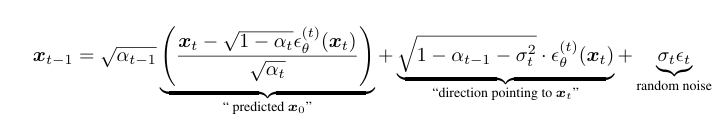

DDIM follows the equation above for its reverse process. 

If variance is equal to the equation above, then the process simply becomes Markovian and generation reverts back to the DDPM approach. If it however becomes equal to 0, the forward process of generation becomes deterministic as the coefficient before the random noise t becomes zero.The resulting model becomes an implicit probabilistic model, coined as the Denoising Diffusion Implicit Model which is the model implemented in this assignment, and we are left with the equation below:

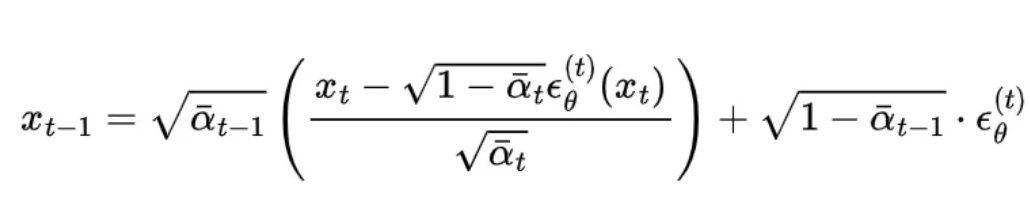

In this new equation, noise is not added to the data because variance is 0. The only noise retained is the orignal noise at X0 as the denoising process becomes completely deterministic, and the use of Markov Chain for probability is now redundant.

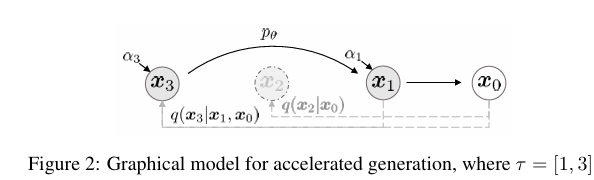

Based on the figure above, X3 can immediately proceed to X1 as X2 can now be skipped. 

For the loss function that we will employ, we will be following András Béres' recommendation from the Denoising Diffusion Implicit Models paper where mean squared error (MSE) and mean absolute error (MAE) are used for the loss function of DDIM. Now that we have explained the rationale behind DDIM, we can proceed to define it.

In [3]:
#defined class for the configuration settings of our DDIM model
@dataclass(frozen=True)#ensures that attributes of the class cannot be changed after creation
class DiffusionModelConfig:

    num_timesteps: int #number of time steps set to integer
    target_type: str = "pred_eps" #determines what the model is predicting
    noise_schedule_type: str = "cosine" #set to "cosine"
    loss_type: str = "l2" #set to "l2"

    def __post_init__(self): #performs checks and assertions on the attributes to ensure they meet required settings
        assert self.num_timesteps > 0 #num_timesteps should be greater than 0
        assert self.target_type in ("pred_x_0", "pred_eps", "pred_v")#target types
        assert self.noise_schedule_type in ("linear", "cosine")
        assert self.loss_type in ("l1", "l2")

#defined our DDIM Diffusion Model class
class DiffusionModel(nn.Module):

    def __init__(#takes input shape, neural network module, and a configuration as arguments
        self,
        input_shape: tuple[int, ...],
        nn_module: nn.Module,
        config: DiffusionModelConfig,
    ):
        super().__init__()#initializes attributes: input shape, neural network module, number of time steps, target type, noise schedule type, and loss type
        self.input_shape = input_shape
        self.nn_module = nn_module
        self.num_timesteps = config.num_timesteps
        self.target_type = config.target_type
        self.noise_schedule_type = config.noise_schedule_type
        self.loss_type = config.loss_type

        #input shape must be either (c,) or (c, h, w) or (c, t, h, w)
        assert len(input_shape) in (1, 3, 4)

        #constructed a noise schedule based on the specified noise schedule type and in our case, we selected cosine
        #parameterized by a sequence of scaling factors,alpha_t,which controls the amount of noise added to the input data at each time step
        if self.noise_schedule_type == "linear":#here, scaling factors alpha_t are linearly decreasing over time
            beta_t = torch.linspace(1e-4, 2e-2, self.num_timesteps + 1)#initialized as a linearly spaced sequence between 1e-4 and 2e-2, inclusive, with self.num_timesteps + 1 elements
            alpha_t = torch.cumprod(1 - beta_t, dim=0) ** 0.5 #alpha_t is then computed as the cumulative product of (1 - beta_t) raised to the power of 0.5
        elif self.noise_schedule_type == "cosine": #here, scaling factors alpha_t follow a cosine-shaped decay pattern
            linspace = torch.linspace(0, 1, self.num_timesteps + 1) #initialized as a linearly spaced sequence between 0 and 1, inclusive, with self.num_timesteps + 1 elements
            f_t = torch.cos((linspace + 0.008) / (1 + 0.008) * math.pi / 2) ** 2 #f_t is computed as the squared cosine of the scaled linspace, which oscillates between 0 and 1
            bar_alpha_t = f_t / f_t[0] #normalizing f_t to ensure that it starts at 1
            beta_t = torch.zeros_like(bar_alpha_t) #beta_t is then calculated as the difference between consecutive elements of bar_alpha_t, clamped to the range [0, 0.999]
            beta_t[1:] = (1 - (bar_alpha_t[1:] / bar_alpha_t[:-1])).clamp(min=0, max=0.999)
            alpha_t = torch.cumprod(1 - beta_t, dim=0) ** 0.5 #alpha_t is computed as the cumulative product of (1 - beta_t) raised to the power of 0.5
            #here, noise level decreases smoothly over time following a cosine shape
        else:
            raise AssertionError(f"Invalid {self.noise_schedule_type=}.") #ensures that only valid noise schedule types are used
        
        #ensures the computed scaling factors alpha_t have the correct shape, then the sigma_t, the standard deviation of the noise distribution, is calculated based on these scaling factors
        #Since alpha_t is computed as a sequence of scaling factors for each time step, it is expected to have a shape of (num_timesteps + 1,)
        #These tensors are of shape (num_timesteps + 1, *self.input_shape)
        #For example, if self.input_shape represents a 2D input, alpha_t will be reshaped to (num_timesteps + 1, 1, 1, 1) to match the shape of the 2D input
        #If it is a 1D input: (num_timesteps + 1, 1)
        alpha_t = unsqueeze_to(alpha_t, len(self.input_shape) + 1) #reshapes scaling factors for the noise at each time step and ensures that alpha_t has the same number of dimensions as the input data
        sigma_t = (1 - alpha_t ** 2).clamp(min=0) ** 0.5 #sigma_t, the standard deviation of the noise distribution at each time step, is calculated based on the scaling factors alpha_t
        self.register_buffer("alpha_t", alpha_t) #registered as buffers
        self.register_buffer("sigma_t", sigma_t)
    
    #defined function that calculates the loss incurred by the diffusion model during training by comparing the predicted target with the ground truth target, based on the diffusion process and the specified loss type    
    def loss(self, x: torch.Tensor):
        
        bsz, *_ = x.shape
        t_sample = torch.randint(1, self.num_timesteps + 1, size=(bsz,), device=x.device) #randomly sampled time steps between 1 and self.num_timesteps + 1 for each sample in the batch
        eps = torch.randn_like(x) #eps is generated with the same shape as the input tensor x
        x_t = self.alpha_t[t_sample] * x + self.sigma_t[t_sample] * eps #applies the scaling factors and noise levels to the input data using the diffusion process equation
        pred_target = self.nn_module(x_t, t_sample) #input x_t is passed through the neural network module along with the corresponding sampled time steps
        #predicts the target
        
        #computes Ground Truth Target based on specified target_type
        if self.target_type == "pred_x_0":
            gt_target = x
        elif self.target_type == "pred_eps":
            gt_target = eps
        elif self.target_type == "pred_v":
            gt_target = self.alpha_t[t_sample] * eps - self.sigma_t[t_sample] * x
        else:
            raise AssertionError(f"Invalid {self.target_type=}.")

        #loss is calculated based on the difference between the predicted target and the ground truth target
        if self.loss_type == "l2": #computes the mean squared error loss if loss type is l2
            loss = 0.5 * (gt_target - pred_target) ** 2
        elif self.loss_type == "l1": #computes the mean absolute error loss if loss type is l1
            loss = torch.abs(gt_target - pred_target)
        else:
            raise AssertionError(f"Invalid {self.loss_type=}.")

        return loss #returns the calculated loss tensor with shape (bsz, *input_shape)

    #defined function that generates samples from the diffusion model (sampling function)
    @torch.no_grad() #ensures that no gradients are computed during the execution of this function
    def sample(self, bsz: int, device: str, num_sampling_timesteps: int | None = None):
        
        num_sampling_timesteps = num_sampling_timesteps or self.num_timesteps #if num_sampling_timesteps is not provided, it defaults to self.num_timesteps
        assert 1 <= num_sampling_timesteps <= self.num_timesteps #ensures number of sampling time steps is within valid range

        x = torch.randn((bsz, *self.input_shape), device=device) #random input x is generated using Gaussian noise with the specified batch size and input shape
        #represents the start and end time steps for sampling
        t_start = torch.empty((bsz,), dtype=torch.int64, device=device)
        t_end = torch.empty((bsz,), dtype=torch.int64, device=device)
        
        #represents the sequence of time steps to sample, ranging from self.num_timesteps to 0, with num_sampling_timesteps + 1 steps
        subseq = torch.linspace(self.num_timesteps, 0, num_sampling_timesteps + 1).round()
        samples = torch.empty((num_sampling_timesteps + 1, bsz, *self.input_shape), device=device)
        samples[-1] = x

        #Note that t_start > t_end we're traversing pairwise down subseq.
        #For example, subseq here could be [500, 400, 300, 200, 100, 0]
        #iterates over each pair of consecutive time steps
        for idx, (scalar_t_start, scalar_t_end) in enumerate(zip(subseq[:-1], subseq[1:])):
            # For each pair, it fills t_start and t_end with the respective time step values
            t_start.fill_(scalar_t_start)
            t_end.fill_(scalar_t_end)
            #generates noise based on the end time step. If the end time step is 0, it uses zeros as noise.
            noise = torch.zeros_like(x) if scalar_t_end == 0 else torch.randn_like(x)

            gamma_t = 0.0 #set to 0 because we are using ddim, if we were using ddpm, the equations discussed above would have been reflected here

            #diffusion process are applied to generate the samples
            #pred_x_0 and pred_eps are calculated based on the neural network predictions and the target type
            nn_out = self.nn_module(x, t_start)
            if self.target_type == "pred_x_0":
                pred_x_0 = nn_out
                pred_eps = (x - self.alpha_t[t_start] * nn_out) / self.sigma_t[t_start]
            elif self.target_type == "pred_eps":
                pred_x_0 = (x - self.sigma_t[t_start] * nn_out) / self.alpha_t[t_start]
                pred_eps = nn_out
            elif self.target_type == "pred_v":
                pred_x_0 = self.alpha_t[t_start] * x - self.sigma_t[t_start] * nn_out
                pred_eps = self.sigma_t[t_start] * x + self.alpha_t[t_start] * nn_out
            else:
                raise AssertionError(f"Invalid {self.target_type=}.")

            #The final sample x is computed using the equations representing the reverse diffusion process
            x = (
                (self.alpha_t[t_end] * pred_x_0) +
                (self.sigma_t[t_end] ** 2 - gamma_t ** 2).clamp(min=0) ** 0.5 * pred_eps +
                (gamma_t * noise)
            )
            samples[-1 - idx - 1] = x #generated sample x is stored in the samples tensor at the appropriate index
            #samples are stored in reverse order, where index 0 corresponds to the initial input x, index t corresponds to the sample at time step t, and the last index corresponds to the random noise
        return samples #generated samples are tensors with shape (num_sampling_timesteps + 1, bsz, *self.input_shape)

## Dataset and Preprocessing

Now that we have defined our model, the next step is to prepare the Cifar 10 dataset to be used for training and evaluation. Since we will be loading the dataset from Openml, the datasets have already been split into 50,000 Train set and 10,000 Test set by default. We will, however, further split the train set (50,000) into a train and validation set with allocations of 80% for train set and 20% for validation sets. Aside from splitting the dataset, we will also preprocess the dataset so it fits the expected inputs of the DDIM model we've defined. Firstly, we will augment the Cifar 10 dataset by performing random horizontal flips to help the model learn additional features as images are shown in different angles or perspectives. On top of augmenting the data using horizontal flips, we will be employing normalization on the Cifar 10 dataset as well. This will be done by normalizing input data based on the mean and standard deviation values. Normalization is done by subtracting the mean from each channel and dividing the standard deviation for each channel. This process ensures that the input data has a mean of zero and a standard deviation of one for each channel.

In [4]:
#represents the mean & standard deviation values for each channel in the dataset
#both are initialized to [0.5, 0.5, 0.5]
dataset_mean, dataset_sd = np.asarray([0.5, 0.5, 0.5]), np.asarray([0.5, 0.5, 0.5])
dataset = datasets.CIFAR10(
    "./data/cifar_10",
    train=True,#indicates that we are using the training set
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),#performed data augmentation technique -- horizontal flip
        transforms.ToTensor(),#converted the dataset to tensors since our Model expects inputs to be in this form
        transforms.Normalize(dataset_mean, dataset_sd),#normalizes input data based on the provided mean and standard deviation values
    ])
)

batch_size = 8 #set batch size to 8 for simplicity. All batch sizes moving forward will be set to 8 for simplicity and uniformity; we do not want to further complicate our approach as we have limited compute power

#Split the dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#Created DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In the next step, we will be using the same approach to create a test dataset to be used specifically for evaluation purposes. However, since we will only be using this for evaluation, we will not be employing the augmentation technique of random flips as we want the model's performance to be tested on real actual data.

In [5]:
#created test set
dataset_mean, dataset_sd = np.asarray([0.5, 0.5, 0.5]), np.asarray([0.5, 0.5, 0.5])
test_dataset = datasets.CIFAR10(
    "./data/cifar_10",
    train=False, #set to False to get the default test set
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),#converted to tensors as required by our defined model
    ])
)

#Created DataLoaders for test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## TRAINING

Before we begin our training, we will first create a function that generates visualizations at different time steps of samples generated by our model so that we can visualize the samples generated by our trained model. Then, the function will save samples of the generated images and the original images used for comparison, if needed, by the user.

In [6]:
def samples_generated(name,bsz,dataset):
    
    model_best = torch.load(name + '.model')#Loads the saved best model from our training
    model_best.eval() #sets the model in evaluation mode since we are only after the generation of samples

    samples = model_best.sample(bsz, num_sampling_timesteps=20, device=device).cpu().numpy()
    samples = samples * rearrange(dataset_sd, "c -> 1 1 c 1 1") + rearrange(dataset_mean, "c -> 1 1 c 1 1")#reverses the normalization applied to the samples during preprocessing to ensure that the samples are in the original data distribution
    samples = np.rint(samples * 255).clip(min=0, max=255).astype(np.uint8)

    x_vis = rearrange(dataset.data[:8], "b h w c -> b c h w")

    nrows, ncols = 4, 2
    percents = (100, 75, 50, 25, 0)
    raster = np.zeros((3, nrows * 32, ncols * 32 * (len(percents) + 1)), dtype=np.uint8)

    for i in range(nrows * ncols):
        row, col = i // ncols, i % ncols
        raster[:, 32 * row : 32 * (row + 1), 32 * col : 32 * (col + 1)] = x_vis[i]
    for percent_idx, percent in enumerate(percents):
        itr_num = int(round(0.01 * percent * (len(samples) - 1)))
        for i in range(nrows * ncols):
            row, col = i // ncols, i % ncols
            offset = 32 * ncols * (percent_idx + 1)
            raster[:, 32 * row : 32 * (row + 1), offset + 32 * col : offset + 32 * (col + 1)] = samples[itr_num][i]

    raster = rearrange(raster, "c h w -> h w c")
    plt.imsave("new_ex_cifar.png", raster, vmin=0, vmax=255)
    
    # Save the image of x_vis[0]
    plt.imsave("original_images/x_vis_0.png", x_vis[0].transpose(1, 2, 0), vmin=0, vmax=255)
    
    # Save the image of samples[itr_num][0]
    plt.imsave("generated_images/noise_0.png", samples[itr_num][0].transpose(1, 2, 0), vmin=0, vmax=255)
    
    # Save the image of x_vis[1]
    plt.imsave("original_images/x_vis_1.png", x_vis[1].transpose(1, 2, 0), vmin=0, vmax=255)
    
    # Save the image of samples[itr_num][1]
    plt.imsave("generated_images/noise_1.png", samples[itr_num][1].transpose(1, 2, 0), vmin=0, vmax=255)
    
    # Save the image of x_vis[2]
    plt.imsave("original_images/x_vis_2.png", x_vis[2].transpose(1, 2, 0), vmin=0, vmax=255)
    
    # Save the image of samples[itr_num][2]
    plt.imsave("generated_images/noise_2.png", samples[itr_num][2].transpose(1, 2, 0), vmin=0, vmax=255)
    
    # Save the image of x_vis[3]
    plt.imsave("original_images/x_vis_3.png", x_vis[3].transpose(1, 2, 0), vmin=0, vmax=255)
    
    # Save the image of samples[itr_num][3]
    plt.imsave("generated_images/noise_3.png", samples[itr_num][3].transpose(1, 2, 0), vmin=0, vmax=255)

Now, we can begin training the model.

In [7]:
#Start measuring time
start_time = time.time()

logging.basicConfig(level=logging.INFO) #used logger for the display of the loss values
logger = logging.getLogger(__name__)

nn_module = UNet(3, 128, (1, 2, 4, 8)) #assigned our UNet class to the nn module to be used as argument of our defined DDIM model
model = DiffusionModel(#assigned our DDIM model to model variable 
    nn_module=nn_module,
    input_shape=(3, 32, 32,),
    config=DiffusionModelConfig(
        num_timesteps=500,
        target_type="pred_x_0",
        noise_schedule_type="cosine",
    ),
)

device = torch.device("cpu")
model = model.to(device)

iterations = 50 #set iterations to 50 to avoid complicating the training as we are limited by computing resources
batch_size = 8 #set batch size to 8 to avoid complicating the training as we are limited by computing resources
name = 'ddim'
max_patience = 10 #set max patience to 10 so training can be stopped early if it does not improve anymore
best_nll = 1000 #initialized nll

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01) #set Adam as optimizer to be used
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations) #set scheduler

#performed training
iterator = iter(train_loader)
for step_num in range(iterations):
    try:
        x_batch, _ = next(iterator)
    except StopIteration:
        iterator = iter(train_loader)
        x_batch, _ = next(iterator)
    x_batch = x_batch.to(device)
    optimizer.zero_grad()
    loss = model.loss(x_batch).mean()
    loss.backward()
    optimizer.step()
    scheduler.step()

    logger.info(f"Iter: {step_num}\t" + f"Loss: {loss.data:.2f}\t")
    
    #code block below ensures that we will be saving the best model and that training can stop early if model does not improve anymore
    if iterations == 0:
        print('saved!')
        torch.save(model, name + '.model')
        best_nll = loss
    else:
        if loss < best_nll:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss
            patience = 0
            samples_generated(name, bsz = 8,dataset=train_dataset.dataset) #calls samples generated function for the best model so we can visualize the generated samples            
        else:
            patience = patience + 1

    if patience > max_patience:
        break

#End measuring time
end_time = time.time()

#Calculated execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

INFO:__main__:Iter: 0	Loss: 0.24	


saved!


INFO:__main__:Iter: 1	Loss: 0.28	
INFO:__main__:Iter: 2	Loss: 0.13	


saved!


INFO:__main__:Iter: 3	Loss: 0.11	


saved!


INFO:__main__:Iter: 4	Loss: 0.13	
INFO:__main__:Iter: 5	Loss: 0.07	


saved!


INFO:__main__:Iter: 6	Loss: 0.09	
INFO:__main__:Iter: 7	Loss: 0.06	


saved!


INFO:__main__:Iter: 8	Loss: 0.04	


saved!


INFO:__main__:Iter: 9	Loss: 0.05	
INFO:__main__:Iter: 10	Loss: 0.06	
INFO:__main__:Iter: 11	Loss: 0.05	
INFO:__main__:Iter: 12	Loss: 0.05	
INFO:__main__:Iter: 13	Loss: 0.07	
INFO:__main__:Iter: 14	Loss: 0.03	


saved!


INFO:__main__:Iter: 15	Loss: 0.07	
INFO:__main__:Iter: 16	Loss: 0.05	
INFO:__main__:Iter: 17	Loss: 0.05	
INFO:__main__:Iter: 18	Loss: 0.07	
INFO:__main__:Iter: 19	Loss: 0.03	
INFO:__main__:Iter: 20	Loss: 0.04	
INFO:__main__:Iter: 21	Loss: 0.07	
INFO:__main__:Iter: 22	Loss: 0.07	
INFO:__main__:Iter: 23	Loss: 0.06	
INFO:__main__:Iter: 24	Loss: 0.04	
INFO:__main__:Iter: 25	Loss: 0.05	


Execution time: 372.72 seconds


Next, we will also be showing how we tried training our DDIM model below with a validation set. However, it takes so long to run. It takes around 30 minutes only for 1 iteration of training while the one above (without validation) takes only around 7-10 minutes already for 50 iterations. This is because of the complicated loss function computation of the DDIM which requires powerful computing resources. First, we define an evaluation function which can be used for the training with validation, and later on, evaluation on the test dataset.

In [10]:
#defined evaluation function
def evaluation(val_loader,step_num, model):
    #Validation loop
    model.eval()#set the model to evaluation mode since we will only be performing evaluation
    with torch.no_grad():
        val_loss = 0.0
        for x_val, _ in val_loader:
            x_val = x_val.to(device)
            val_loss += model.loss(x_val).mean().item()
        val_loss /= len(val_loader)
    
    print(f"Iter: {step_num}, val nll={val_loss}")
    
    return val_loss

In [26]:
#performed training with validation and set the same parameters as the training earlier except for the iterations
#set iterations only to 5 as it takes so long to train with validation and we are limited by computing resources

#Start measuring time
start_time = time.time()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

nn_module = UNet(3, 128, (1, 2, 4, 8))
model = DiffusionModel(
    nn_module=nn_module,
    input_shape=(3, 32, 32,),
    config=DiffusionModelConfig(
        num_timesteps=500,
        target_type="pred_x_0",
        noise_schedule_type="cosine",
    ),
)

device = torch.device("cpu")
model = model.to(device)

best_nll = 1000

iterations = 5
batch_size = 8
bsz = 8
name = 'ddim'
max_patience = 10

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

iterator = iter(train_loader)
for step_num in range(iterations):
    model.train()
    try:
        x_batch, _ = next(iterator)
    except StopIteration:
        iterator = iter(train_loader)
        x_batch, _ = next(iterator)
    x_batch = x_batch.to(device)
    optimizer.zero_grad()
    loss = model.loss(x_batch).mean()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    #Validation
    loss_val = evaluation(val_loader,step_num, model) #called evaluation function above on the validation set

    if iterations == 0:
        print('saved!')
        torch.save(model, name + '.model')
        best_nll = loss_val
    else:
        if loss_val < best_nll:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
            patience = 0
            samples_generated(name, bsz = 8,dataset=val_dataset.dataset)            
        else:
            patience = patience + 1

    if patience > max_patience:
        break

#End measuring time
end_time = time.time()

#Calculated execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Files already downloaded and verified
Iter: 0, val nll=0.10863190258443356
saved!
Iter: 1, val nll=0.12399642062485218
Iter: 2, val nll=0.1174785275220871
Iter: 3, val nll=0.11028484817743302
Iter: 4, val nll=0.10427494784593583
saved!
Execution time: 8834.93 seconds


In [33]:
8834.93/60

147.24883333333335

As seen above, the training with validation lasted for almost 3 hours for only 5 iterations. Due to this, we opted to move forward with the results of the trained model without the validation set since it ran on 50 iterations and because it is more convenient to run considering that we have limitations on compute power.

## EVALUATION

In the next steps, we will be evaluating the performance of the best trained DDIM model. Firstly, we will be evaluating its performance by using the loss function used earlier on the test dataset.

In [11]:
#called the defined evaluation function on the test dataset
#Start measuring time
start_time = time.time()

#load saved best performing model
model_best = torch.load(name + '.model')

step_num = iterations

test_loss = evaluation(test_loader,step_num, model=model_best)

#End measuring time
end_time = time.time()

#Calculate execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Iter: 50, val nll=0.3430016825556755
Execution time: 1665.33 seconds


Next, we will be defining a function that when called, we can easily see the original images used from the dataset.

In [13]:
#defined samples real function
def samples_real(name, test_loader):
    num_x = 4
    num_y = 2
    x = next(iter(test_loader))[0].detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.transpose(x[i], (1, 2, 0)) 
        ax.imshow(plottable_image)
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()

Next, we call the samples_real and samples_generated functions to see the results of the first phase of the evaluation of the trained best model on the test dataset.

In [14]:
samples_real(name, test_loader)

In [15]:
samples_generated(name, bsz = 8, dataset=test_dataset)

## Frechet Inception Distance

Next, we will be evaluating the performance of our best trained model using Frechet Inception Distance (FID). FID measures the similarity between two datasets of images by calculating the Fréchet distance between two Gaussians fitted to feature representations of neural networks. Our implementation will closely follow the principles discussed in the paper GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium by Heusel et al. However, the researchers' approach leveraged on tensorflow and since we are using PyTorch for our implementation, we will be using mseitzer's implementation instead, as it is a well-known approach of calculating Frechet Inception Distance using PyTorch. 

In [16]:
#defined a function that zips all the files and folders found within a specified folder
def zip_folder(folder_path, zip_file_name):
    with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))


In [17]:
#set the paths to the original images and generated images folders respectively
path1 = "original_images"
path2 = "generated_images"

In [18]:
#zipped the original images
folder_to_zip = path1
zip_file_name = 'original_zip.zip'
zip_folder(folder_to_zip, zip_file_name)

In [19]:
#zipped the generated images
folder_to_zip = path2
zip_file_name = 'generated_zip.zip'
zip_folder(folder_to_zip, zip_file_name)

In [33]:
#defined a function that calculates the mean and variance of the images when called
def compute_image_stats(archive_file1,img_type):

    #Paths to the image datasets
    archive_file1 = archive_file1

    batchSize = 8 #set to 8 for consistency and simplicity
    num_imgs = 4 #since we have samples of 4 earlier
    device = torch.device("cpu")

    #Open the zip files
    archive1 = zipfile.ZipFile(archive_file1, 'r')

    #Read the image data
    data = []
    for filename in archive1.filelist:
        with archive1.open(filename.filename) as file:
            image_bytes = file.read()
            image = Image.open(io.BytesIO(image_bytes))
            data.append(image)

    #Loads the data
    archive1.close()
    img_data = np.concatenate((data), axis=0)
    del data

    #Shuffles the data
    np.random.shuffle(img_data)

    #Converts the data to a tensor
    img_data = torch.tensor(img_data, dtype=torch.uint8, device=device)

    #Reshapes the tensor
    img_data = img_data.reshape(img_data.shape[0], 32, 4)

    #Gets a subset of the data
    img_data = img_data[:num_imgs]
    
    #Since we will be using InceptionV3, followed the normalization approach proposed by the InceptionV3 page from PyTorch
    def normalize(imgs):
        #Converts images to 299x299
        imgs = transforms.Compose([transforms.Resize((299,299))])(imgs)

        #Standardizez to [0, 1]
        imgs = imgs/255.0
    
        #Normalizes the inputs
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
        imgs = (imgs - mean) / std
        return imgs

    #Loads in the inception network
    inceptionV3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', weights="Inception_V3_Weights.DEFAULT")
    inceptionV3.eval()
    inceptionV3.to(device)

    #Removes the fully connected output layer
    inceptionV3.fc = nn.Identity()
    inceptionV3.aux_logits = False

    #Calculates the inception scores
    scores = None
    with torch.no_grad():
        for i in range(math.ceil(num_imgs/batchSize)):
            #Gets the current batch size
            cur_batch_size = min(num_imgs, batchSize*(i+1))-batchSize*i

            #Gets the current batch of images
            imgs = img_data[batchSize*i:cur_batch_size+(batchSize*i)]
            
            #Adds a dummy dimension for the channel
            imgs = imgs.unsqueeze(1)

            #Normalizes the inputs
            imgs = normalize(imgs.to(torch.float))
            
            device = torch.device("cpu")

            #Calculates the inception scores and stores them
            if type(scores) == type(None):
                scores = inceptionV3(imgs.to(device)).to(device).numpy().astype(np.float16)
            else:
                scores = np.concatenate((scores, inceptionV3(imgs.to(device)).to(device).numpy().astype(np.float16)), axis=0)

    #Deletes the model as its no longer needed
    del inceptionV3

    #Calculates the mean and covariance of the generated batch
    mean = np.mean(scores, axis=0)
    var = np.cov(scores, rowvar=False)
    
    if img_type == 'original':
        #Saves the mean and variance of original images
        np.save("original_mean.npy", mean)
        np.save("original_var.npy", var)
    else:
        #Saves the mean and variance of generated images
        np.save("generated_mean.npy", mean)
        np.save("generated_var.npy", var)

In [34]:
#computes image stats for the original images
archive_file1 = 'original_zip.zip'
img_type = 'original'
compute_image_stats(archive_file1,img_type)

Using cache found in C:\Users\rodul/.cache\torch\hub\pytorch_vision_v0.10.0


In [35]:
#computes image stats for the generated images
archive_file2 = 'generated_zip.zip'
img_type = 'generated'
compute_image_stats(archive_file2,img_type)

Using cache found in C:\Users\rodul/.cache\torch\hub\pytorch_vision_v0.10.0


In [36]:
#defined the function that calculates the FID using the two mean and two variance files created
def compute_FID():

    #Mean and variance files
    mean_file1 = "original_mean.npy"
    mean_file2 = "generated_mean.npy"
    var_file1 = "original_var.npy"
    var_file2 = "generated_var.npy"

    #Loads in the mean and variances
    mean1 = np.load(mean_file1)
    mean2 = np.load(mean_file2)
    var1 = np.load(var_file1)
    var2 = np.load(var_file2)

    #calculates the sum squared difference between means
    ssdiff = np.sum((mean1 - mean2)**2.0)

    #calculates sqrt of product between cov
    covmean = sqrtm(var1.dot(var2))

    #checks and corrects imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    #calculates score
    fid = ssdiff + np.trace(var1 + var2 - 2.0 * covmean)
    return fid

In [37]:
#calculated FID
compute_FID()

176.58294619627503

FID score is very high hinting at the great disparity between the distributions of the two sets of images.

# Visualization of Samples Generated

Earlier, we have already generated samples using our best model. In this portion, we will visualize said images.

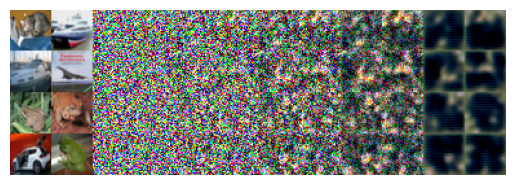

In [25]:
#Load the image
img = mpimg.imread('new_ex_cifar.png')

#Display the image
plt.imshow(img)
plt.axis('off')
plt.show()


##### Analyze and discuss the quality of the generated samples

The ones on the left are the original images while the ones on the right are the generated samples.The generated samples lack discernible shapes, structures, or recognizable features present in the original data. This suggests that the generative process or model is not effectively capturing the essential characteristics of the original images. The discrepancy between the generated samples and the original images indicates a significant loss of information during the generation process. This loss of information is probably due to the limitations in the model architecture, and inadequate optimization of training parameters. My device does not have GPU and does not have a very powerful computing cpu power; hence, I found it very challenging to run the training of the model at high iterations, especially if we train with a validation set. A training run with only one iteration coupled with validation on the dataset roughly lasts up to 30 minutes; hence, the best performing model used throughout this report was from a model trained without validation set, and was only trained in 50 iterations. This result is supported by the very high FID score of 176.58 that indicates a substantial dissimilarity between the generated samples and the real data. Since FID score measures the distance between the distributions of features extracted from the generated samples and the real data, a higher FID score suggests a significant mismatch between these distributions. Therefore, a score of 176.58 indicates a substantial dissimilarity, implying that the generated samples diverge considerably from the real data, which explains the poor quality of the generated images. However, it is also important to note that if one looks closely at the generated images, one can notice that there are high concentrations of smudges on locations where there are objects and their respective features are supposed to be located or detected, which will be made clearer later on as we visualize the representations learned by our trained model using the Class Activation Map.

# Gradient Class Activation Map

In order to visualize and interpret the learned representations of our best trained model, we will be using the Gradient Class Activation Map method discussed by Abhishek Agarwal in Visualizing Convolutional Neural Networks. In a neural network, the final classification step usually involves taking the average of all the outputs from the previous layer and passing that average through a classifier.However, instead of averaging, if we looked at each individual pixel's contribution to the classifier, we could create a heatmap showing which pixels are most important for the classifier. These heatmaps are the intended outputs of Class Activation Maps. Now, Gradient Class Activation Maps take this idea further by weighting the unpooled output with the mean of the gradient of the predicted label scores of the pixels to the last filter instead of weighting the unpooled output with the Linear layer weights.

In [26]:
#load saved best performing model
model_best = torch.load(name + '.model')

In [27]:
#defined two global scope variables to store our gradients and activations
gradients = {}
activations = {}

#defined a function that sets up a hook to capture gradients during the backward pass of the neural network
def getGradients(name):
    #defined function that serves as a hook that gets triggered during the backward pass of the neural network training
    def backward_hook(module, grad_input, grad_output):#takes the layer/module for which the backward hook is triggered; gradient of the loss with respect to the inputs and outputs of the layer/module as arguments
        print(f"Backward hook triggered")#confirms that the hook is being called
        gradients[name] = grad_output #stores gradient outputs in a dictionary called gradients
    return backward_hook

#defined a function that sets up a hook to capture activations during the forward pass of the neural network
def getActivations(name):
    #defined function that serves as a hook that gets triggered during the forward pass of the neural network training
    def forward_hook(module, args, output):#takes the layer/module for which the forward hook is triggered; activations with respect to the inputs and outputs of the layer/module as arguments
        print(f"Forward hook triggered")#confirms that the hook is being called
        activations[name] = output #stores activation outputs in a dictionary called activations
    return forward_hook

In [28]:
#registered backward hook on the last layer of our UNet
backward_hook = model_best.nn_module.out_blocks[-1].register_backward_hook(getGradients('lastLayer'))

#registered forward hook on the last layer of our UNet
forward_hook = model_best.nn_module.out_blocks[-1].register_forward_hook(getActivations('lastLayer'))

In [29]:
#Defined transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),  #Resized the image to (128, 128)
    transforms.ToTensor(),           #Converted the image to a tensor
    transforms.Normalize(            #Normalized the image with mean and standard deviation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
   )
])

#set path to one of the images from the original images folder
img_path = 'original_images/x_vis_1.png'
img = Image.open(img_path)

#Converts RGBA image to RGB image since our functions are designed to work on RGB images
if img.mode == 'RGBA':
    img = img.convert('RGB')

num_timesteps = 1 #set to 1 for simplicity

t = torch.randn(num_timesteps).long()

img_tensor = transform(img) #transforms the image for uniformity

print("t.shape", t.shape)
print("img_tensor.shape", img_tensor.shape)

print("t.ndim:", t.ndim)
print("img_tensor:", img_tensor.ndim)

model_best.eval() #set best trained model to evaluation mode
output = model_best.nn_module(transform(img).unsqueeze(0),t) #fed the image to the model
logit = model_best.nn_module.forward(output,t)  #Called the forward method of the UNet instance to trigger a forward pass using the output of the model when the image was fed

loss = model_best.loss(output) #fed output to loss and assigned to loss variable
loss = loss.mean()  #Convert loss to a scalar by taking the mean
optimizer.zero_grad() #set optimizer to zero grad
loss.backward(retain_graph=True) #triggered a backward pass so hooks can be triggered
optimizer.step()

h_x = F.softmax(logit, dim=1).data.squeeze()

probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()

t.shape torch.Size([1])
img_tensor.shape torch.Size([3, 128, 128])
t.ndim: 1
img_tensor: 3
Forward hook triggered


C:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Forward hook triggered
Forward hook triggered
Backward hook triggered
Backward hook triggered


In [30]:
#pooled the gradients across the channels
pooled_gradients = torch.mean(gradients['lastLayer'][0], dim=[0, 2, 3])

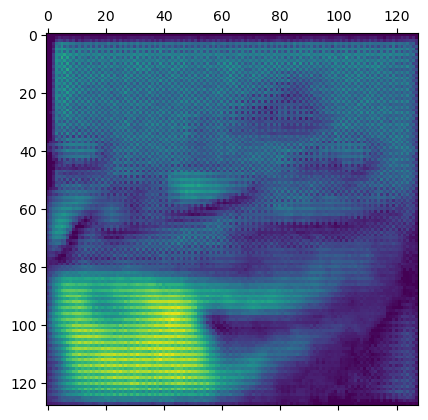

In [31]:
#weighted the channels by corresponding gradients
for i in range(activations['lastLayer'].size()[1]):
    activations['lastLayer'][:, i, :, :] *= pooled_gradients[i]

#got the average of the channels of the activations
heatmap = torch.mean(activations['lastLayer'], dim=1).squeeze()

#used relu on top of the heatmap
heatmap = F.relu(heatmap).detach().cpu().numpy()

#normalized the heatmap
heatmap = heatmap - np.min(heatmap)
heatmap_img = heatmap / np.max(heatmap)
heatmap_img = np.uint8(255 * heatmap_img)

#displayed the heatmap
plt.matshow(heatmap_img)

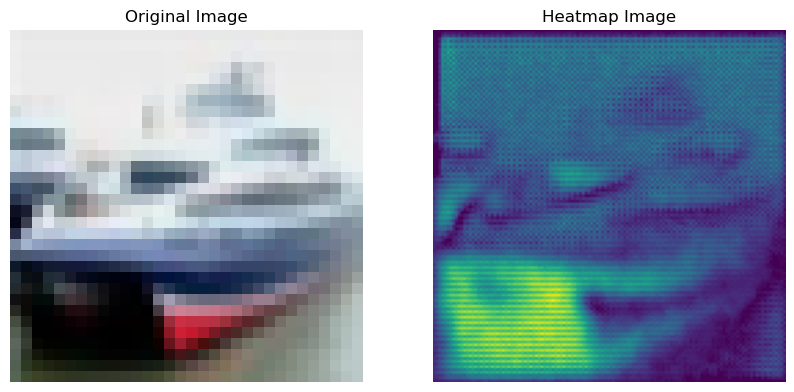

In [32]:
#displayed the original and heatmap images side-by-side for easier comparison

#Load the images
original_img_path = 'original_images/x_vis_1.png'

#Read the image
original_img = mpimg.imread(original_img_path)

#Created a figure and axis
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

#Plotted the original image
axes[0].imshow(original_img)
axes[0].set_title('Original Image')
axes[0].axis('off')

#Plotted the heatmap image
axes[1].imshow(heatmap_img)
axes[1].set_title('Heatmap Image')
axes[1].axis('off')

#Show the images
plt.show()


Upon closer inspection of the displayed images, it becomes evident that there are clusters of distortions in areas where objects and their defining features are expected to be found or identified. This observation becomes more apparent as we can see that the heat signatures from the image on the right seem to outline a shape that forms the same shape as the ship from the left photo.This suggests that the model is indeed learning the features, and with additional fine-tuning and optimizations, it is likely to produce higher-quality generated samples in the future.

# References

1. DENOISING DIFFUSION IMPLICIT MODELS by Jiaming Song, Chenlin Meng & Stefano Ermon: https://arxiv.org/pdf/2010.02502

2. CIFAR_10: https://www.openml.org/search?type=data&status=active&id=40927&sort=runs

3. U-Net: Convolutional Networks for Biomedical Image Segmentation: chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1505.04597

4. Deep Residual Learning for Image Recognition by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7780459

5. Phil Wang's denoising-diffusion-pytorch: https://github.com/lucidrains

6. Denoising Diffusion Probabilistic Models by Jonathan Ho, Ajay Jain, Pieter Abbeel: https://arxiv.org/abs/2006.11239

7. Appendix: Architecture Choices by Tony Duan: https://www.tonyduan.com/diffusion/architecture.html

8. Deep Generative Modeling by Jakub M. Tomczak (2022)

9. Denoising Diffusion Implicit Models by András Béres: https://keras.io/examples/generative/ddim/

10. Diffusion Models — DDPMs, DDIMs, and Classifier Free Guidance by Gabriel Mongaras: https://betterprogramming.pub/diffusion-models-ddpms-ddims-and-classifier-free-guidance-e07b297b2869#092e

11. Note on Variants of Diffusion Scheduler, DDPM DDIM PNDM by Binxu: https://animadversio.github.io/academic_notes/note-on-ddpm-ddim-pndm

12. Diffusion Models From Scratch by Tony Duan: https://www.tonyduan.com/diffusion/index.html

13. Normalizing Images in PyTorch: https://sparrow.dev/pytorch-normalize/

14. Gabriel Mongaras' Diffusion Models From Scratch: https://github.com/gmongaras/Diffusion_models_from_scratch/blob/main/README.md

15. Frechet Distance: https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance

16. GANsTrained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium by Heusel et al: https://arxiv.org/pdf/1706.08500

17. FID score for PyTorch by mseitzer: https://github.com/mseitzer/pytorch-fid/blob/master/README.md

18. INCEPTION_V3: https://pytorch.org/hub/pytorch_vision_inception_v3/

19. Fréchet Inception Distance (FID) for Pytorch by hukkelas: https://github.com/hukkelas/pytorch-frechet-inception-distance/blob/master/readme.md

20. Visualizing Convolutional Neural Networks by Abhishek Agarwal: https://medium.com/@ultimateabhi/visualizing-convolutional-neural-networks-9b06543c09bf

21. Asif Ahmed's Pytorch Diffusion: https://github.com/quickgrid/pytorch-diffusion/tree/main

22. Filippo Maria Bianchi's Diffusion models tutorial: https://github.com/FilippoMB/Diffusion_models_tutorial/blob/main/README.md

23. Arjun Krishna's Denoising_Diffusion_Probabilistic_Model_(DDPMs):https://colab.research.google.com/github/aju22/DDPM/blob/main/Denoising_Diffusion_Probabilistic_Model_(DDPMs).ipynb

24. ddpm_example from workshop week 5

25. Zhao di's Denoising Diffusion Implicit Models: https://github.com/Alokia/diffusion-DDIM-pytorch

26. labml.ai's  annotated_deep_learning_paper_implementations: https://github.com/labmlai/annotated_deep_learning_paper_implementations

27. What is Sampling?: https://stable-diffusion-art.com/samplers/#What_is_Sampling

28. ermongroup's DDIM: https://github.com/ermongroup/ddim

29. Training a Classifier: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html